# UFO 1 data analysis part 1

Big Data házi feladat, UFO1 feladatkör EDA analízise, adatfelderítése.

A használathoz feltételezzük, hogy már létezik egy állomány, data.csv néven, ami tartalmazza a szükséges adatokat.

Ennek a notebooknak a célja, hogy a letöltött adatokkal megismerkedjünk, néhány megfigyelést állapítsunk meg róluk, esetlegesen a nem megfelelő adatokat kiemeljük, és töröljük a készletből.


## Adatok betöltése, átalakítása

Az egyszerű betöltés után néhány kisebb módosítást végeztünk az adatokon:
* Date / Time osztlop átnevezése Date-re, az kezelhetőbbség kedvéért
* Shape oszlop értékei nem voltak konzisztensen kis vagy nagybetűsek, ezért ezeket egységesen csupa lowercase-re konvertáltuk
* A dátumok feldolgozásához a Python saját parser-ét használtuk
    * Amit az nem volt képes feldolgozni, azt egy nem előforduló értékre állítottuk, amit majd később ki lehet szűrni / el lehet dobni
    * Mivel az eredeti adatok szintaxisa miatt jövőbeni adatokat talált a parser, ezért ezeket kézzel módosítottuk

In [1]:
%matplotlib inline
import pandas
import matplotlib
import time
import random
import math
matplotlib.style.use("default")

In [2]:
start = time.time()

# Load data (labels are not included)
raw_data = pandas.read_csv("data.csv", sep=";", encoding="UTF8", header=None, skiprows=1)

STATES = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", \
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", \
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", \
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", \
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

data, wrong_data, skipped_lines = [], [], 0
for _, d in raw_data.iterrows():
    try:
        # Transform or validate data
        date = pandas.to_datetime(d[0])
    except Exception as e:
        date = pandas.NaT
    
    try:
        posted = pandas.to_datetime(d[6])
    except Exception as e:
        posted = pandas.NaT
    
    # State transformation and validation against prebuilt set.
    state = d[2]
    if state is not pandas.np.NaN:
        state = d[2].upper()
        if state not in STATES:
            state = pandas.np.NaN
    
    # Unknown shapes are, according to the website, categorized as unspecified
    shape = d[3].lower() if d[3] is not pandas.np.NaN else "unspecified"
    row = (date, d[1], state, shape, d[4], d[5], posted, d[7])

    # Do some checks...
    if date.date() > posted.date():
        wrong_data.append(row)
        continue

    # Add data to cleaned array
    data.append(row)
    
names = ["Date", "City", "State", "Shape", "Duration", "Summary", "Posted", "Description"]
data = pandas.DataFrame.from_records(data, columns=names)
wrong_data = pandas.DataFrame.from_records(wrong_data, columns=names)

print('Loading data took ' + str(time.time() - start) + 's')
print('Raw data: ' + str(len(raw_data)) + ' lines')
print('Processed data: ' + str(len(data)) + ' lines')
print('Skipped because of parser exception: ' + str(skipped_lines) + ' lines')
print('Wrong data: ' + str(len(wrong_data)) + ' lines')

Loading data took 114.95125317573547s
Raw data: 113241 lines
Processed data: 111536 lines
Skipped because of parser exception: 0 lines
Wrong data: 1705 lines


## Adatok feltérképezése

### Használt oszlopok és típusai, valamint néhány mintaadat

In [3]:
print(data.dtypes)
sample_data = []
for i in range(10):
    sample_data.append(data.iloc[random.randint(0,len(data))])
pandas.DataFrame.from_records(sample_data, columns=names)

Date           datetime64[ns]
City                   object
State                  object
Shape                  object
Duration               object
Summary                object
Posted         datetime64[ns]
Description           float64
dtype: object


,Date,City,State,Shape,Duration,Summary,Posted,Description
0,1997-03-17 21:00:00,San Diego,CA,circle,20 minutes,phoenix lights over san diego,2006-10-30,NaN
1,2015-11-20 22:50:00,Hickory,NC,other,5 minutes,V-shaped object with 6 white lights and 1 red ...,2015-11-26,NaN
2,2003-08-31 22:35:00,Dansville,NY,fireball,2 MINUTES,We saw a large fireball in the sky below a cei...,2003-12-19,NaN
3,1992-08-11 02:40:00,Scofield Reservoir,UT,changing,15 minutes,"More details are in my mind,but I almost can r...",2011-01-31,NaN
4,1998-09-15 23:00:00,Auke Bay,AK,light,1.5 hours,"A very bright light, small red glow on top. O...",1998-09-26,NaN
5,2005-02-03 21:30:00,Fort Collins,CO,triangle,9 seconds,Triangle craft spotted in Fort Collins Colorado,2005-02-22,NaN
6,2014-01-17 17:00:00,Harrisburg,PA,unspecified,5 minutes,2 fireballs in sky.,2014-01-24,NaN
7,2003-02-23 20:30:00,New York City (Astoria; Queens),NY,circle,About 1 Hr,I was out side smoking when I looked up and sa...,2003-03-21,NaN
8,2016-09-04 08:45:00,Portage,WI,circle,Few seconds,White beam of light shot up from ground to tre...,2016-09-09,NaN
9,1992-06-25 00:00:00,Big Bear Lake area,CA,changing,20 minutes,"jello-y lights, it transformed before our eyes.",2003-03-11,NaN


#### Adatszótár

| Oszlop |Adat típusa|Adat típusa feldolgozási szempontból                |Adat jelentősége
|:--------|:-----------|:----------------------------------------------------|:---------------------------
|Date    |datetime   |Eredetileg dd/mm/yy típusú dátum, amit feldolgoztunk|Észlelés dátuma, ez alapján történik az időbeli elhelyezés
| City   |String     |Szabad szavas szöveg, amit komplex kiértékelés nélkül felhasználunk| Város név, ami alapján geolokációval pontosabb lokációt határozhatunk meg
| State  |String     |Két karakteres állam kód (ha releváns, pl USA észlelések) |Ezeket felhasználva hajthatunk végre egy durvább vizualizációt
| Shape |String|Kategorikus adat, az élszelt UFO alakja|Ezen információk alapján csoportosítást vagy klaszterezést végezhetünk az adatokon
| Duration |String|Szabad szavas, rosszul normalizált időtartam mező, melyre egy best effort parseolást adunk|Csoportosítási, klaszterezési műveleteket hajthatunk végre az adaton, vagy kimutatást készíthetünk belőle
| Summary |String|Rövid szabad szavas leírás az eseményről|A feladatok szempontjából nem releváns
| Posted |datetime|dd/mm/yy formátumú dátum strig formában |Az észlelés feltöltésének ideje, validációs célokra, kimutatásokra használható, a feladat szempontjából nem releváns
| Description |String|Külön HTML oldalon elérhető hosszabb leírás, feldolgozása túl nagy terhelést okozna az eredeti szervernek, így nem használjuk|-

### Adatok vizualizációja az észlelés ideje alapján

count      52.000000
mean     2141.788462
std      2513.494874
min         1.000000
25%       273.250000
50%       382.000000
75%      4221.750000
max      8641.000000
Name: Date, dtype: float64


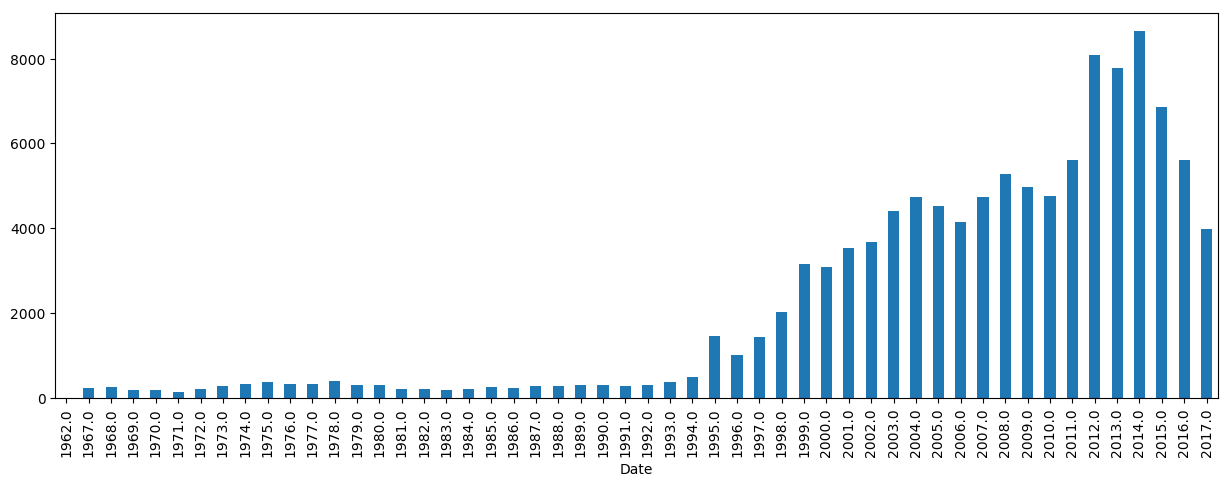

In [4]:
by_year = data.groupby(data["Date"].dt.year).count()["Date"]
print(by_year.describe())
data.groupby(data["Date"].dt.year).count()["Date"].plot(figsize=(15,5),kind="bar")

A valamint vizualizációból látszik, hogy az adatok nagy része 2000 utánról származik.

### Adatok vizualizációja az észlelt ufók száma alapján, alak szerint csoportosítva

count       31.000000
mean      3597.935484
std       4949.340777
min          1.000000
25%          5.000000
50%       1707.000000
75%       5797.000000
max      22817.000000
Name: Shape, dtype: float64


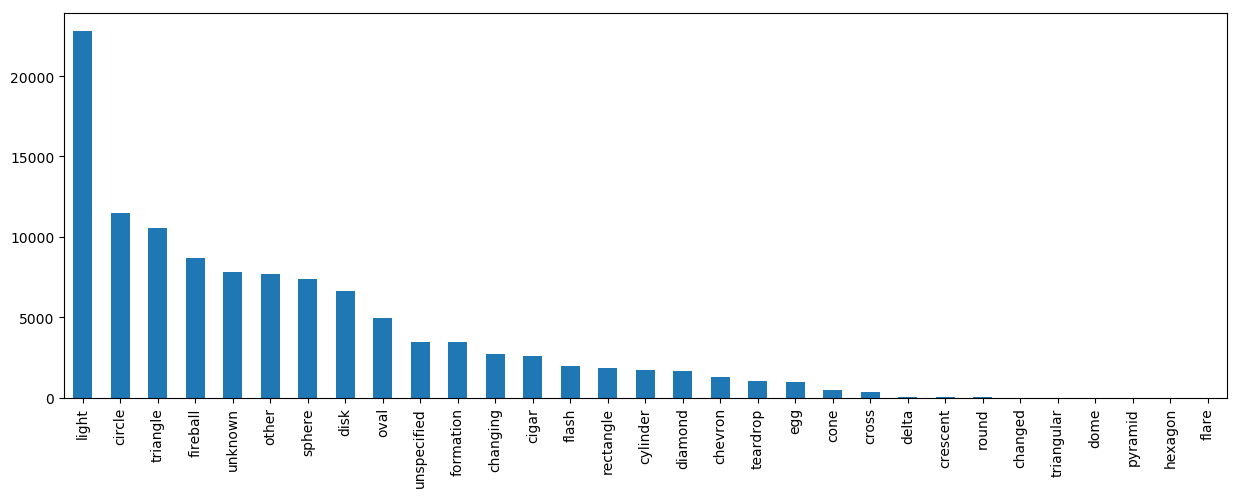

In [5]:
shape_counts = data["Shape"].value_counts()
print(shape_counts.describe())
shape_counts.plot(figsize=(15,5),kind="bar")

Látható, hogy az alak szerinti csoportosításnál a 3. kvartilis beli adatok adják a jelentős részét az adatoknak, így ennél a pontnál lehet érdemes szétválasztani a bonyolultabb vizualizációkat, ha az adatok arányai eltorzítják a képet.

### Adatok leíró statisztikái a City és a State oszlop szerint

In [6]:
by_city = data.groupby("City").count()["Date"]
by_city.describe()

count    24593.000000
mean         4.519863
std         16.204006
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        644.000000
Name: Date, dtype: float64

Az adatok város szerinti vizsgálatából látszik (különösen hogy a 3. kvartilis és az átlag értéke ilyen alacsony a maximumhoz, és az általunk várt értékhez képest), hogy nagyon sok különböző várost adtak meg az adathalmazban, amiből sok olyan van (első, második kvartilis értékei), ami vagy egyszeri észlelés , vagy ami valószínűbb, hogy valami elírás, vagy hibásan felvitt adat.

In [7]:
by_state = data.groupby("State").count()["Date"]
by_state.describe()

count       50.000000
mean      1965.540000
std       2083.079512
min        189.000000
25%        842.250000
50%       1324.000000
75%       2255.500000
max      12750.000000
Name: Date, dtype: float64

Az állam szerinti csoportosításnál úgy tűnik sikeres volt az adatok validációja és transzformációja, mert ezek szerint 1 kivételével mindegyik államból jelentettek észlelést. A qvartilisek, valamint a min és max értékek sem szembetűnően kiugróak a vártakhoz képest.

### Vizualizációs feladat megoldásának terve

A feladat szerint meg kell jelenítenünk az UFO észleléseket térbeli, és időbeli eloszlásuk szerint.
Erre megoldásnak az alábbi vizualizációt tervezzük megvalósítani:
* ~~PySpark segítségével, Map - Reduce módszerrel elkészítjük az egyes évekhez tartozó megfigyelések számát, állam szerint~~
* ~~Ezeket egy 2D pont diagrammon ábrázoljuk, X tengelyen az államokat, Y tengelyen az éveket.~~
* ~~Ábrázolásnál az adatok számosságának jelölésére színeket és/vagy méreteket használunk.~~

A koncepciót az alábbi ábra szemlélteti:

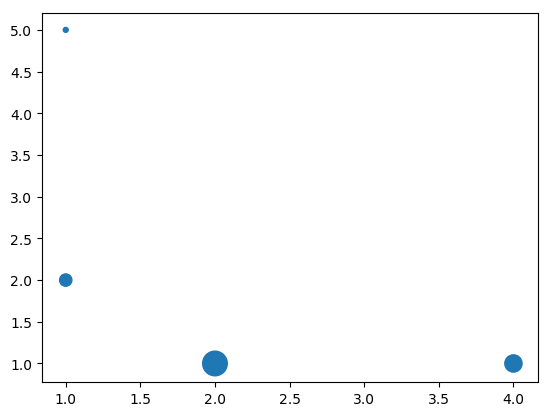

In [8]:
concept = [{"x":2,"y":1,"count":10},{"x":1,"y":2,"count":5},{"x":1,"y":5,"count":2},{"x":4,"y":1,"count":7}]
concept_df = pandas.DataFrame.from_records(concept)
matplotlib.pyplot.scatter(concept_df["x"],concept_df["y"],s=concept_df["count"]**2 * math.pi)

A konzultáció és a munka közbeni tapasztalatok alapján elvetettük a scatter plot alapú megjelenítést, mert az egy túlzsúfolt vizualizációhoz vezetne. Ehelyett a cél vagy egy heatmap alapú vizualizáció használata, a scatter plot-hoz hasonló felépítésben, vagy a pythonos bokeh library által nyújtott USA államok térbeli adataival egy, a következőhöz hasonló vizualizáció létrehozása: https://bokeh.pydata.org/en/latest/docs/gallery/texas.html